In [15]:
import os
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [16]:
data_paths = {
    'train': './data/cassavaleafdata/train',
    'valid': './data/cassavaleafdata/validation',
    'test': './data/cassavaleafdata/test'
}

labels_dict = {
    "cbb": "Cassava Bacterial Blight (CBB)",
    "cbsd": "Cassava Brown Streak Disease (CBSD)",
    "cgm": "Cassava Green Mottle (CGM)",
    "cmd": "Cassava Mosaic Disease (CMD)",
    "healthy": "Healthy"
}

### Preprocessing & DataLoader

In [17]:
img_size = 150

train_transforms_cassava = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

# Load datasets
cassava_train_data = datasets.ImageFolder(root=data_paths['train'], transform= train_transforms_cassava)
cassava_valid_data = datasets.ImageFolder(root=data_paths['valid'], transform=train_transforms_cassava)
cassava_test_data = datasets.ImageFolder(root=data_paths['test'], transform=train_transforms_cassava)

print(f"Cassava - Train: {len(cassava_train_data)}, Valid: {len(cassava_valid_data)}, Test: {len(cassava_test_data)}")

Cassava - Train: 5656, Valid: 1889, Test: 1885


In [18]:
BATCH_SIZE_CASSAVA = 256

cassava_train_dataloader = data.DataLoader(cassava_train_data, shuffle=True, batch_size=BATCH_SIZE_CASSAVA)
cassava_valid_dataloader = data.DataLoader(cassava_valid_data, batch_size=BATCH_SIZE_CASSAVA)
cassava_test_dataloader = data.DataLoader(cassava_test_data, batch_size=BATCH_SIZE_CASSAVA)

In [19]:
class LeNetClassifier(nn.Module):
    def __init__(self, num_classes, in_channels = 1, img_size= 28):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels, out_channels=6,
            kernel_size=5, padding='same')
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()

        # Calculate fc input size dynamically
        if img_size == 28:
            fc_input = 16 * 5 * 5
        else:  # for 150x150 images
            fc_input = 16 * 35 * 35

        self.fc_1 = nn.Linear(fc_input, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, num_classes)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.avgpool1(outputs)
        outputs = F.relu(outputs)
        outputs = self.conv2(outputs)
        outputs = self.avgpool2(outputs)
        outputs = F.relu(outputs)
        outputs = self.flatten(outputs)
        outputs = self.fc_1(outputs)
        outputs = self.fc_2(outputs)
        outputs = self.fc_3(outputs)
        return outputs

In [20]:
def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = model(inputs)

        loss = criterion(predictions, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)

        if idx % log_interval == 0 and idx > 0:
            print(f"| epoch {epoch:3d} | {idx:5d}/{len(train_dataloader):5d} batches | accuracy {total_acc / total_count:8.3f}")
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count if total_count > 0 else 0
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss


def evaluate(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)
            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss


### Train Cassava Model

In [21]:
# model setup
num_classes_cassava = len(cassava_train_data.classes)
cassava_model = LeNetClassifier(num_classes_cassava, in_channels=3, img_size=150).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cassava_model.parameters(), lr=2e-4)

# Training loop
num_epochs = 10
save_model = './model'
os.makedirs(save_model, exist_ok=True)

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs + 1):
    epoch_start_time = time.time()

    # Training
    train_acc, train_loss = train(cassava_model, optimizer, criterion,
                                   cassava_train_dataloader, device, epoch, log_interval=10)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(cassava_model, criterion, cassava_valid_dataloader, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        best_loss_eval = eval_loss
        torch.save(cassava_model.state_dict(), os.path.join(save_model, 'lenet_cassava_model.pt'))

    # Print results
    print("-" * 80)
    print(f"| End of epoch {epoch:3d} | Time: {time.time() - epoch_start_time:5.2f}s | "
          f"Train Acc: {train_acc:8.3f} | Train Loss: {train_loss:8.3f} | "
          f"Valid Acc: {eval_acc:8.3f} | Valid Loss: {eval_loss:8.3f} |")
    print("-" * 80)

# Load best model
cassava_model.load_state_dict(torch.load(os.path.join(save_model, 'lenet_cassava_model.pt'), weights_only=True))
cassava_model.eval()

| epoch   1 |    10/   23 batches | accuracy    0.440
| epoch   1 |    20/   23 batches | accuracy    0.470
--------------------------------------------------------------------------------
| End of epoch   1 | Time: 14.51s | Train Acc:    0.464 | Train Loss:    1.383 | Valid Acc:    0.470 | Valid Loss:    1.442 |
--------------------------------------------------------------------------------
| epoch   2 |    10/   23 batches | accuracy    0.460
| epoch   2 |    20/   23 batches | accuracy    0.479
--------------------------------------------------------------------------------
| End of epoch   2 | Time: 14.80s | Train Acc:    0.500 | Train Loss:    1.321 | Valid Acc:    0.471 | Valid Loss:    1.430 |
--------------------------------------------------------------------------------
| epoch   3 |    10/   23 batches | accuracy    0.468
| epoch   3 |    20/   23 batches | accuracy    0.502
--------------------------------------------------------------------------------
| End of epoch   3 

LeNetClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_1): Linear(in_features=19600, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=5, bias=True)
)

### 🎯 Inference Function for Cassava


Cassava Leaf Disease Inference Examples:


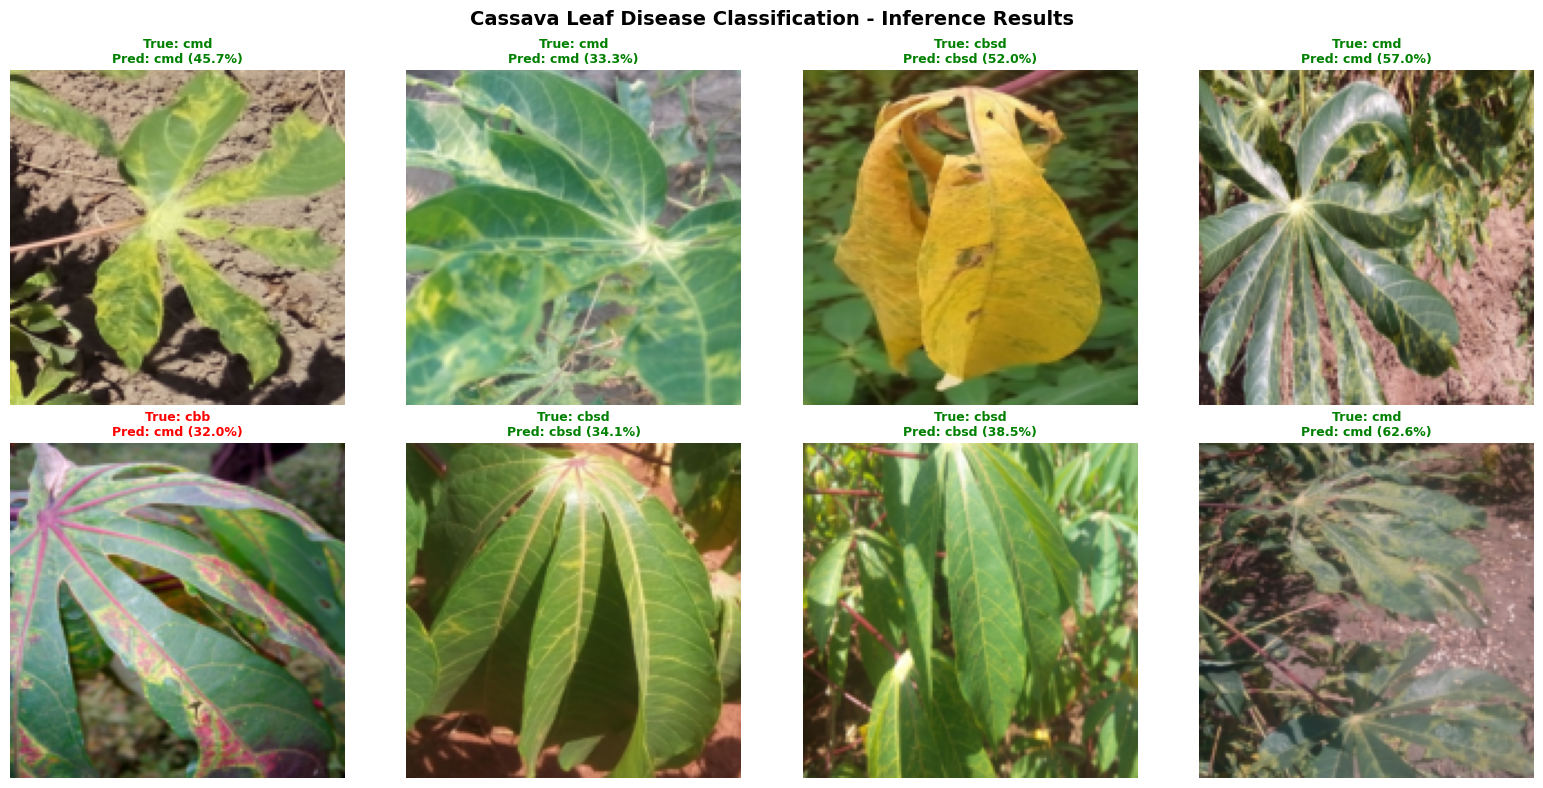

Inference completed for 8 random samples!
Green = Correct prediction, Red = Wrong prediction
Disease Labels:
  - cbb: Cassava Bacterial Blight (CBB)
  - cbsd: Cassava Brown Streak Disease (CBSD)
  - cgm: Cassava Green Mottle (CGM)
  - cmd: Cassava Mosaic Disease (CMD)
  - healthy: Healthy


In [22]:
def inference_cassava(image_path_or_tensor, model, transform, device, labels_dict):
    """Predict cassava disease from image"""
    # Load image if path is provided
    if isinstance(image_path_or_tensor, str):
        image = Image.open(image_path_or_tensor).convert('RGB')
        image_tensor = transform(image)
    else:
        image_tensor = image_path_or_tensor

    # Add batch dimension
    if image_tensor.dim() == 3:
        image_tensor = image_tensor.unsqueeze(0)

    image_tensor = image_tensor.to(device)

    model.eval()
    with torch.no_grad():
        predictions = model(image_tensor)

    probs = nn.Softmax(dim=1)(predictions)
    confidence, predicted_class = torch.max(probs, 1)

    # Get class names
    idx_to_class = {v: k for k, v in cassava_train_data.class_to_idx.items()}
    predicted_label = idx_to_class[predicted_class.item()]
    disease_name = labels_dict[predicted_label]

    return predicted_label, disease_name, confidence.item() * 100

# Test inference on random test images
print("Cassava Leaf Disease Inference Examples:")
print("=" * 70)

n_samples = 8
random_indices = random.sample(range(len(cassava_test_data)), n_samples)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, test_idx in enumerate(random_indices):
    image_tensor, true_label_idx = cassava_test_data[test_idx]

    # Get true label name
    idx_to_class = {v: k for k, v in cassava_train_data.class_to_idx.items()}
    true_label = idx_to_class[true_label_idx]
    true_disease = labels_dict[true_label]

    # Inference
    pred_label, pred_disease, confidence = inference_cassava(
        image_tensor, cassava_model, train_transforms_cassava, device, labels_dict
    )

    # Visualize
    img_to_show = image_tensor.permute(1, 2, 0).numpy()
    axes[idx].imshow(img_to_show)
    color = 'green' if pred_label == true_label else 'red'
    axes[idx].set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)',
                        color=color, fontsize=9, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Cassava Leaf Disease Classification - Inference Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Inference completed for {n_samples} random samples!")
print(f"Green = Correct prediction, Red = Wrong prediction")
print(f"Disease Labels:")
for k, v in labels_dict.items():
    print(f"  - {k}: {v}")


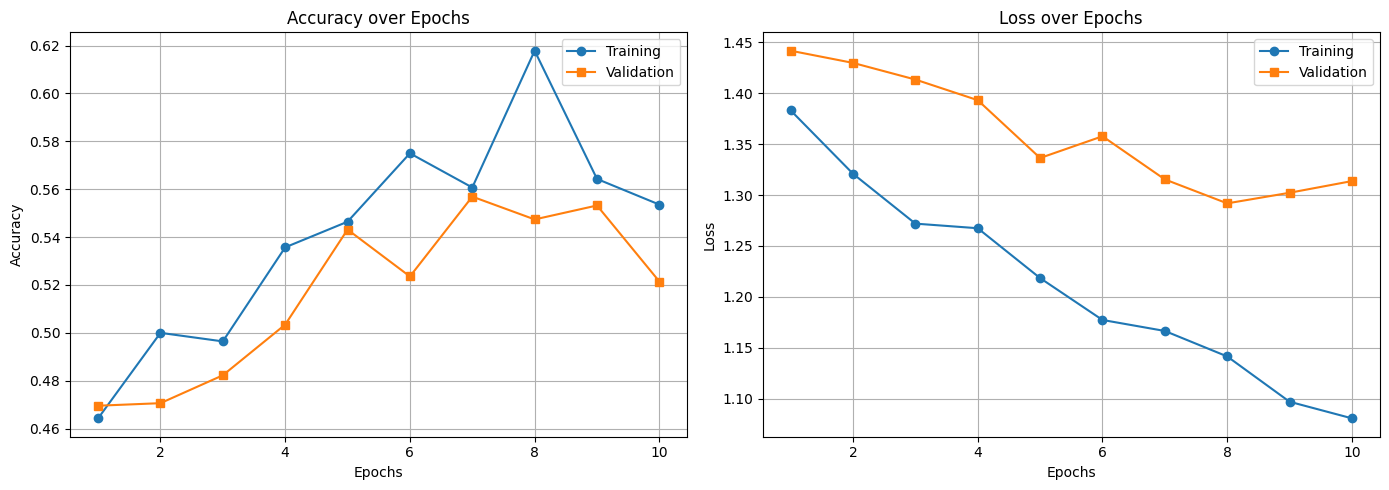

In [23]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(1, num_epochs + 1))
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

    axs[0].plot(epochs, train_accs, label="Training", marker='o')
    axs[0].plot(epochs, eval_accs, label="Validation", marker='s')
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_title("Accuracy over Epochs")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(epochs, train_losses, label="Training", marker='o')
    axs[1].plot(epochs, eval_losses, label="Validation", marker='s')
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")
    axs[1].set_title("Loss over Epochs")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses)


In [24]:
test_acc, test_loss = evaluate(cassava_model, criterion, cassava_test_dataloader, device)
print(f"Cassava Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

Cassava Test Accuracy: 0.5645, Test Loss: 1.2686
